In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformer-based regression model
class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, output_dim, d_model=128, nhead=4, num_layers=4, dim_feedforward=512):
        super(TransformerRegressor, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # Embedding layer (for the input sequence of cosmological parameters)
        self.embedding = nn.Linear(input_dim, d_model)
        
        # Transformer Encoder Layer
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=d_model, 
                nhead=nhead, 
                dim_feedforward=dim_feedforward
            ), num_layers=num_layers
        )
        
        # Final linear layer to map the transformer output to the desired output
        self.fc_out = nn.Linear(d_model, output_dim)

    def forward(self, x):
        x = self.embedding(x)  # shape (batch_size, 1, d_model)
        x = x.permute(1, 0, 2)  # shape (1, batch_size, d_model) for transformer input
        
        # Pass through the transformer
        x = self.transformer(x)
        
        # Take the output of the first (and only) token
        x = x[0, :, :]
        
        # Output layer
        x = self.fc_out(x)
        return x

In [17]:
from sklearn.preprocessing import StandardScaler
from acm.data.io_tools import *

statistic = 'tpcf'
select_filters = {}
slice_filters = {}

X_train, y_train, coords = read_lhc(statistics=[statistic],
                                select_filters=select_filters,
                                slice_filters=slice_filters)
n_input = X_train.shape[1]
n_output = y_train.shape[1]
print(f'Loaded LHC with shape: {X_train.shape}, {y_train.shape}')

# Assuming X_train is your cosmological parameters (n_obs, n_input)
# and y_train is your galaxy correlation function (n_obs, n_output)

# Example: Model instantiation for your problem
model = TransformerRegressor(input_dim=n_input, output_dim=n_output, d_model=128, nhead=4, num_layers=4)
model.to(device)  # Move model to GPU

# Loss and optimizer
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Data loading
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)

# Convert to torch tensors and move to device
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

Loaded LHC with shape: (8500, 20), (8500, 100)


In [18]:
# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, targets in train_loader:
        # Move the batch to the GPU
        inputs = inputs.to(device).unsqueeze(1)
        targets = targets.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate the loss
        loss = criterion(outputs, targets)
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        running_loss += loss.item()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

Epoch [10/1000], Loss: 0.1121
Epoch [20/1000], Loss: 0.0921
Epoch [30/1000], Loss: 0.0823
Epoch [40/1000], Loss: 0.0770
Epoch [50/1000], Loss: 0.0741
Epoch [60/1000], Loss: 0.0721
Epoch [70/1000], Loss: 0.0689
Epoch [80/1000], Loss: 0.0667
Epoch [90/1000], Loss: 0.0658
Epoch [100/1000], Loss: 0.0657
Epoch [110/1000], Loss: 0.0663
Epoch [120/1000], Loss: 0.0642
Epoch [130/1000], Loss: 0.0629
Epoch [140/1000], Loss: 0.0630
Epoch [150/1000], Loss: 0.0627
Epoch [160/1000], Loss: 0.0624
Epoch [170/1000], Loss: 0.0624
Epoch [180/1000], Loss: 0.0615
Epoch [190/1000], Loss: 0.0608
Epoch [200/1000], Loss: 0.0611
Epoch [210/1000], Loss: 0.0598
Epoch [220/1000], Loss: 0.0594
Epoch [230/1000], Loss: 0.0603
Epoch [240/1000], Loss: 0.0594
Epoch [250/1000], Loss: 0.0595
Epoch [260/1000], Loss: 0.0595
Epoch [270/1000], Loss: 0.0582
Epoch [280/1000], Loss: 0.0581
Epoch [290/1000], Loss: 0.0585
Epoch [300/1000], Loss: 0.0572
Epoch [310/1000], Loss: 0.0578
Epoch [320/1000], Loss: 0.0587
Epoch [330/1000],

In [19]:
# Evaluation on the validation set
model.eval()  # Set to evaluation mode
with torch.no_grad():
    # Assuming X_val and y_val are your validation data
    X_val_scaled = scaler_X.transform(X_train)
    y_val_scaled = scaler_y.transform(y_train)
    X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).unsqueeze(1).to(device)
    
    predictions = model(X_val_tensor)
    predictions = predictions.squeeze().cpu().numpy()  # Move predictions back to CPU for further processing
    predictions_original = scaler_y.inverse_transform(predictions)

# You can now use predictions for further analysis

covariance_matrix, n_sim = read_covariance(statistics=[statistic],
                                           select_filters=select_filters,
                                           slice_filters=slice_filters)
errors = np.sqrt(np.diag(covariance_matrix))

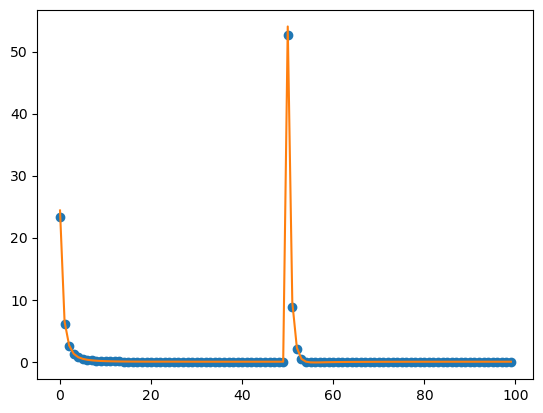

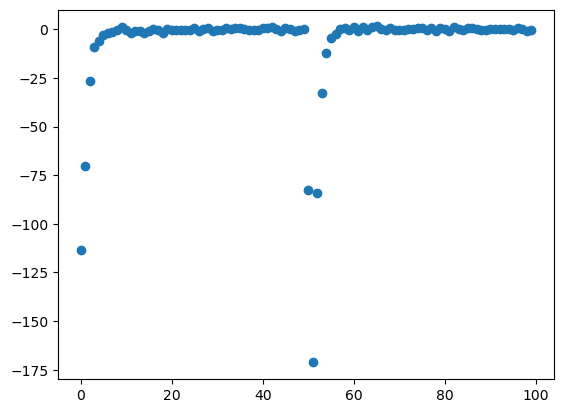

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(y_train[0], marker='o', ls='')
ax.plot(predictions_original[0])
plt.show()

fig, ax = plt.subplots()
ax.plot((y_train[0] - predictions_original[0])/errors, marker='o', ls='')
plt.show()

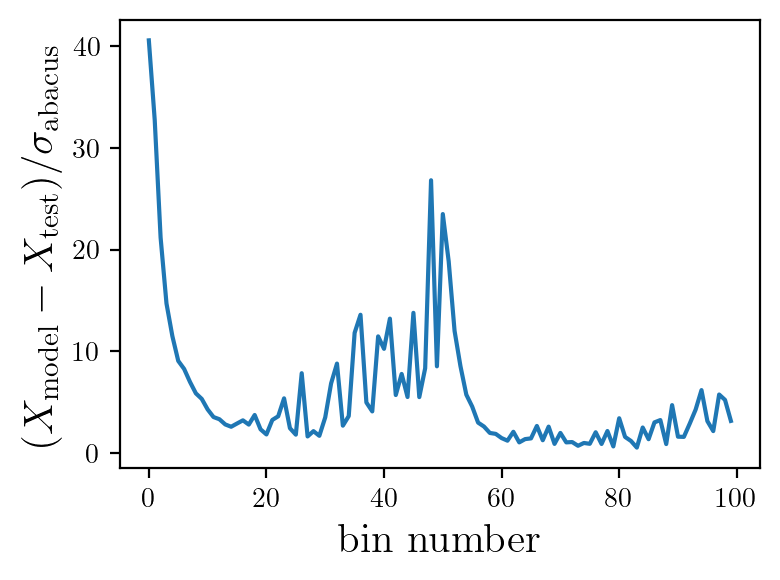

In [3]:
from acm.data.io_tools import *
from sunbird.emulators import Transformer
import torch
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

def get_emulator_error(lhc_test_y, pred_test_y):
    return np.median(np.abs(lhc_test_y - pred_test_y), axis=0)

def plot_emulator_error():
    fig, ax = plt.subplots(figsize=(4, 3))
    emulator_error = get_emulator_error(pred_test_y, lhc_y)
    if statistic == 'number_density':
        ax.plot(emulator_error/np.sqrt(covariance_matrix), marker='o', ms=3.0)
    else:
        ax.plot(emulator_error/np.sqrt(np.diag(covariance_matrix)))
    ax.set_xlabel('bin number', fontsize=15)
    ax.set_ylabel(r'$(X_{\rm model} - X_{\rm test})/\sigma_{\rm abacus}$', fontsize=15)
    plt.tight_layout()
    plt.show()

statistic = 'tpcf'
select_filters = {}
slice_filters = {}

lhc_x, lhc_y, coords = read_lhc(statistics=[statistic],
                                select_filters=select_filters,
                                slice_filters=slice_filters)

covariance_matrix, n_sim = read_covariance(statistics=[statistic],
                                        select_filters=select_filters,
                                        slice_filters=slice_filters)

model_fn = '~/pscratch/emc/v1.1/trained_models/tpcf/cosmo+hod/transformer/optuna/last-v11.ckpt'
model = Transformer.load_from_checkpoint(model_fn, strict=True)
model.eval()
model.to('cpu')

with torch.no_grad():
    pred_test_y, _ = model.forward(torch.Tensor(lhc_x))
    pred_test_y = pred_test_y.numpy()

plot_emulator_error()